# **Regression Trees**

In this seession we will use a real dataset to train a regression tree model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers ahthorized under the Taxicab & Livery Passenger Enchancement Programs (TPEP/LPEP). We will use the trained model to predict the amount of tip paid.

## Objectives

* Perform basic data preprocessing using **Scikit-Learn**
* Model a regression task using **Scikit-Learn**
* Train a **Decision Tree Regressor** model
* Run inference and assess the quality of the trained models

## Introduction
The dataset used is a subset of the publicly available TLC Dataset (all rights reserved by Taxi & Limousine Commission (TLC), City of New York). The prediction of the tip amount can be modeled as a regression problem. To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model.

---

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Dataset Analysis

In [3]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/pu9kbeSaAtRZ7RxdJKX9_A/yellow-tripdata.csv'
raw = pd.read_csv(url)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41202 entries, 0 to 41201
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               41202 non-null  int64  
 1   passenger_count        41202 non-null  int64  
 2   trip_distance          41202 non-null  float64
 3   RatecodeID             41202 non-null  int64  
 4   store_and_fwd_flag     41202 non-null  int64  
 5   PULocationID           41202 non-null  int64  
 6   DOLocationID           41202 non-null  int64  
 7   payment_type           41202 non-null  int64  
 8   fare_amount            41202 non-null  float64
 9   mta_tax                41202 non-null  float64
 10  tolls_amount           41202 non-null  float64
 11  improvement_surcharge  41202 non-null  int64  
 12  tip_amount             41202 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 4.1 MB


From this, we know that all the features in this dataset are all numerical

Check the correlation between all features

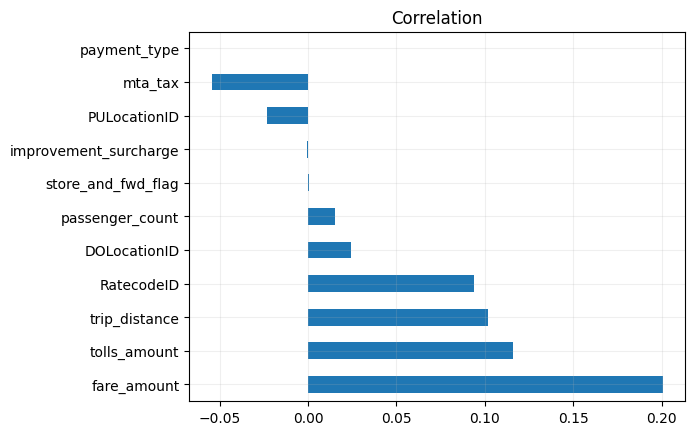

fare_amount              0.200638
tolls_amount             0.116172
trip_distance            0.101819
RatecodeID               0.094075
DOLocationID             0.024348
passenger_count          0.015081
store_and_fwd_flag       0.000320
improvement_surcharge   -0.000727
PULocationID            -0.023086
mta_tax                 -0.054488
payment_type                  NaN
Name: tip_amount, dtype: float64


In [5]:
corr = raw.corr()['tip_amount'].drop(['VendorID','tip_amount']).sort_values(ascending=False)
corr.plot(kind='barh')
plt.title("Correlation")
plt.grid(True, alpha=0.2)
plt.show()

print(corr)

`payment_type`, `'improvement_surcharge`, and `store_and_fwd_flag` have a little to no correlation with the target variable (`tip_amount`).

### Dataset Preprocessing

In [6]:
# 1. Remove Zero Tips (If your goal is to predict "How much do TIPPERS tip?")
# Many credit card users still tip $0. This confuses the model.
data = raw[raw['tip_amount'] > 0]

# 2. Remove Outliers (The "Millionaire" Problem)
# Remove tips over $20 or Fares over $100 ( outliers skew RMSE heavily)
data = data[(data['tip_amount'] < 20) & (data['fare_amount'] < 100)]

# 3. Focus on "Standard Rate" only
# RatecodeID 1 is "Standard". Other codes (JFK, Negotiated) have weird rules.
df_clean = data[data['RatecodeID'] == 1]

# NOW Check Correlation again
print(data[['fare_amount', 'tip_amount']].corr())

data = raw.drop(['VendorID', 'payment_type','store_and_fwd_flag', 'improvement_surcharge'], axis=1)

X = raw.drop(['tip_amount'], axis=1)
y = raw['tip_amount']

             fare_amount  tip_amount
fare_amount     1.000000    0.192827
tip_amount      0.192827    1.000000


### Dataset Train, Test, and Split
Now that the dataset is ready for building the classification models, we need to first divide the pre-processed dataset into a subset to be used for training the model(The train set) and a subset to be used for evaluating the quality of the model (the test set).

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer

# 1. Clean Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ENCODE CATEGORICAL COLUMNS

# Categorical columns
cat_cols = X.select_dtypes('int').columns.to_list()

# PU and DO columns (For target encoder)
ids = ['PULocationID', 'DOLocationID']
cat_cols = [item for item in cat_cols if item not in ids]

# Make Pipeline
preprocessor = ColumnTransformer(
    transformers = [
        # Categorical Columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),

        # ids columns
        ('ids', TargetEncoder(smooth=10), ids)
    ],
    remainder='passthrough',    # pass or ignore remaining features
    verbose_feature_names_out=False  # Keep the names clean
).set_output(transform="pandas") # Set output as DataFrame, not Arrays

# Apply the pipeline
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded = preprocessor.transform(X_test)

# Fit the model
treereg = DecisionTreeRegressor(criterion='squared_error',
                                max_depth=5,
                                random_state=35)
treereg.fit(X_train_encoded, y_train)

DecisionTreeRegressor(max_depth=5, random_state=35)

#### Evaluate Tree Regression Models
To evaluate the model, we will use the `score` method of the `DecisionTreeRegressor` object providing our testing data, this number is the $R^2$ value which indicates the coefficient of determination. We will also evaluate the *Mean Squared Error (MSE)* of the regression output with respect to the test set target values. high $R^2$ and low *MSE* values are expected from a good regression model.

RMSE score: 4.9121
MAE score: 3.5770
R2 score: 0.0448


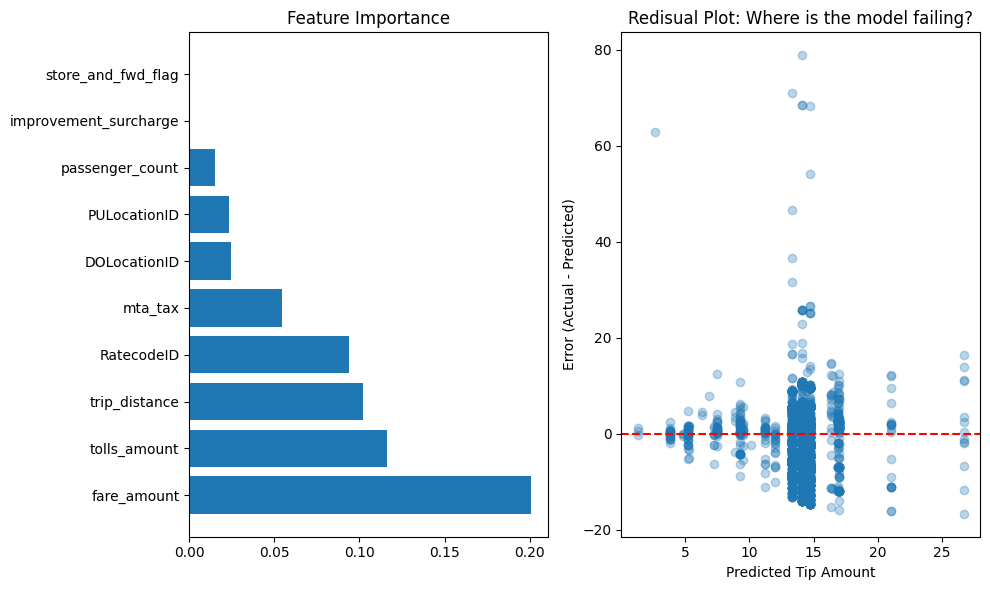

In [8]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

# Predict using the model
y_pred = treereg.predict(X_test_encoded)

# Evaluate mean squared error on the test subset
print(f"RMSE score: {root_mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2 score: {r2_score(y_test, y_pred):.4f}")


# Subplots
fig, ax = plt.subplots(1, 2, figsize=(10,6))

# Residual Plot
residuals = y_test - y_pred
ax[1].scatter(y_pred, residuals, alpha=0.3)
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_xlabel("Predicted Tip Amount")
ax[1].set_ylabel("Error (Actual - Predicted)")
ax[1].set_title("Redisual Plot: Where is the model failing?")

# Feature Importance
corr = raw.corr()['tip_amount'].drop('tip_amount').abs().sort_values(ascending=False)
ax[0].barh(y=corr.index, width=corr.values)
ax[0].set_title("Feature Importance")

plt.tight_layout()
plt.show()


The $R^2$ is extremely low, probably Regression Tree is not the right model to `tip_amount` of this dataset. Decision Trees are terrible at predicting diagonal lines.

---

#### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_encoded, y_train)

y_pred_lr = lr.predict(X_test_encoded)

print(f"RMSE score: {root_mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"R2 score: {r2_score(y_test, y_pred_lr):.4f}")

RMSE score: 4.9000
MAE score: 3.5792
R2 score: 0.0495


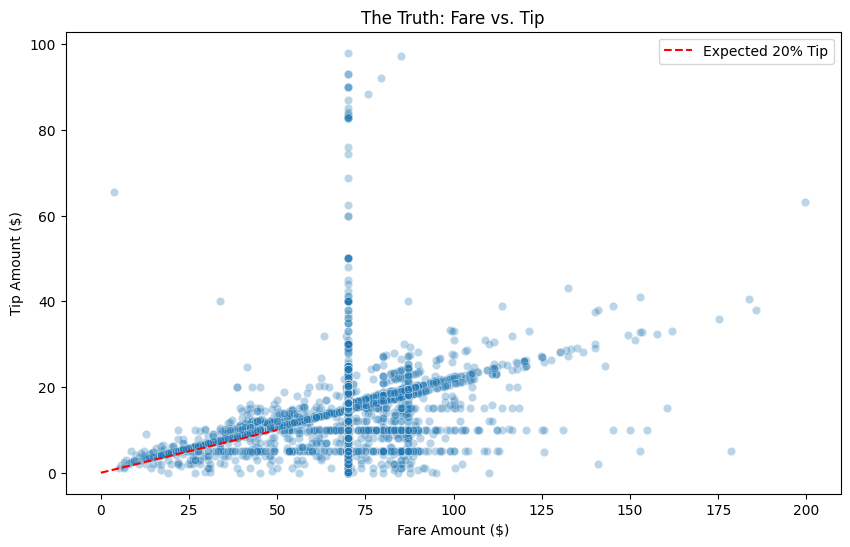

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Plot a sample (first 2000 points) so it doesn't crash your computer
sns.scatterplot(x='fare_amount', y='tip_amount', data=data, alpha=0.3)

plt.title("The Truth: Fare vs. Tip")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Tip Amount ($)")
plt.plot([0, 50], [0, 10], 'r--', label="Expected 20% Tip") # A red line showing where dots SHOULD be
plt.legend()
plt.show()

Even after using Linear Regression, the score is still low. I guess it's just the data problem, or maybe the target was just too unpredictable (`tip_amount`).

---

#### Try Changing the Target to `fare_amount`

In [11]:
# Split the data
X_fare = data.drop('fare_amount', axis=1)
y_fare = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X_fare, y_fare, test_size=0.3, random_state=42)

# ENCODE CATEGORICAL COLUMNS
# Categorical columns
cat_cols = X_fare.select_dtypes('int').columns.to_list()

# PU and DO columns (For target encoder)
ids = ['PULocationID', 'DOLocationID']
cat_cols = [item for item in cat_cols if item not in ids]

# Make Pipeline
preprocessor = ColumnTransformer(
    transformers = [
        # Categorical Columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        # ids columns
        ('ids', TargetEncoder(smooth=10), ids)
    ],
    remainder='passthrough',    # pass or ignore remaining features
    verbose_feature_names_out=False  # Keep the names clean
).set_output(transform="pandas") # Set output as DataFrame, not Arrays

# Apply the pipeline
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded = preprocessor.transform(X_test)

In [12]:
treereg.fit(X_train_encoded, y_train)
y_pred_tree = treereg.predict(X_test_encoded)

print(f"RMSE score: {root_mean_squared_error(y_test, y_pred_tree):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred_tree):.4f}")
print(f"R2 score: {r2_score(y_test, y_pred_tree):.4f}")

RMSE score: 2.5541
MAE score: 0.3652
R2 score: 0.8323


In [13]:
lr.fit(X_train_encoded, y_train)
y_pred_lr = lr.predict(X_test_encoded)

print(f"RMSE score: {root_mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"R2 score: {r2_score(y_test, y_pred_lr):.4f}")

RMSE score: 4.2326
MAE score: 1.5511
R2 score: 0.5394


The result scores on both models are good, especially on Tree model. This proves, that `tip_amount` as a target is too noisy and hard to predict by the models, on the other hand `fare_amount` can be predicted quite well by the models.

#### Possible Strategy

1. They Switch to Classification Instead of asking "How much will they tip?" (Regression), they ask "Will they tip at all?" (Classification). 
    It is much easier to predict Yes/No than $4.52. 
    Business Value: If the app knows a passenger is a "Non-Tipper," maybe it doesn't match them with a Top-Rated Driver.

2. They Accept "Better than Random" In this case, R2 = 0.03 means we are 3% better than just guessing the average.

    In academic homework, 3% is an "F".

    In a hedge fund, being 3% better than the market average is worth billions of dollars.

3. Hunt for "The Missing Variable". The low score proves we are missing a key piece of the puzzle. If we were working at the taxi company, we would ask:

    "Can we get data on the passenger's rating?"

    "Can we see if it was raining?" (People tip more in rain).

    "Can we see if the driver was speeding?" (Lower tips).

---

#### **Try Another Scenario**
Previous target was to predict the amount of tips would be given by the passangers (`tip_amount`). Now, let's try another scenario where we will predict the category of tips given by the passangers. That means, we will move from regression to classification.

The category of tips will follow the "20% Rule":
* **Class 1 (Generous)**: Tipped ≥ **20%** of the fare.
* **Class 0 (Stingy/Standard)**: Tipped < **20%** of the fare.

This effectively normalizes the data:
* A $2 tip on a $5 ride is **Generous** (40%)
* A $2 tip on a $100 ride is **Stingy** (2%)

In [14]:
# Recall the raw data
raw.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,tolls_amount,improvement_surcharge,tip_amount
0,2,1,17.63,2,1,132,164,1,70.0,0.5,6.94,1,16.54
1,2,1,19.52,2,1,132,236,1,70.0,0.5,6.94,1,16.19
2,2,1,17.81,2,1,132,48,1,70.0,0.5,6.94,1,12.00
3,2,2,19.30,2,1,132,148,1,70.0,0.5,0.00,1,5.00
4,2,1,18.75,2,1,132,234,1,70.0,0.5,6.94,1,10.00


In [15]:
# Make a copy
data = raw.copy()

# --- Feature engineering ---
# Create "Tip Percentage" column
data['tip_pct'] = data['tip_amount'] / (data['fare_amount'] + 0.00001) * 100

# Create the tip category column
data['is_generous'] = (data['tip_pct'] >= 20).astype(int)

# Check the balance
print("Class balance")
print(data['is_generous'].value_counts(normalize=True))


Class balance
is_generous
1    0.697151
0    0.302849
Name: proportion, dtype: float64


Good proportion, let's proceed to training the model

In [16]:
# Preprocessing
X_class = data.drop(columns=['tip_amount', 'tip_pct', 'is_generous'])
y_class = data['is_generous']

# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y_class)

# Encoding the features
cat_cols = X_class.select_dtypes('int').columns.to_list()
ids_cols = ['PULocationID', 'DOLocationID']
cat_cols = [item for item in cat_cols if item not in ids_cols]

preprocessor = ColumnTransformer(
    transformers=[
        # Categorical Columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        # Ids columns
        ('ids', TargetEncoder(smooth=10), ids_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Apply the encoder
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded = preprocessor.transform(X_test)

Accuracy Score: 56.21%
=== Detailed Report ===
              precision    recall  f1-score   support

           0       0.30      0.35      0.32      3744
           1       0.70      0.66      0.68      8617

    accuracy                           0.56     12361
   macro avg       0.50      0.50      0.50     12361
weighted avg       0.58      0.56      0.57     12361



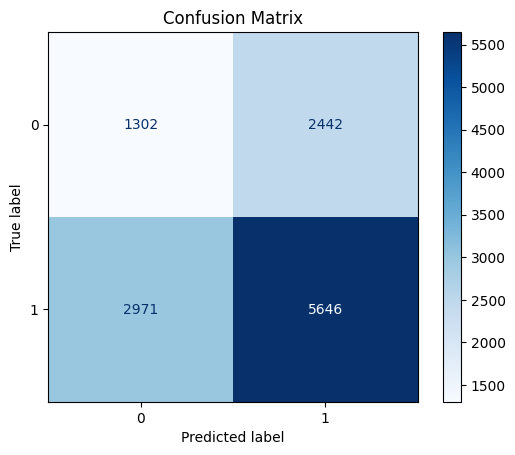

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

# Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42)
clf.fit(X_train_encoded, y_train)

# Predict
y_pred_class = clf.predict(X_test_encoded)

# Evaluate
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_class):.2%}")
print("=== Detailed Report ===")
print(classification_report(y_test, y_pred_class))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()